# Import all the modules
#### Note: As this is a barebone example, dask is not used

In [1]:
# Modules required for computation
import numpy as np
import xarray as xr
import pandas as pd
import time
from glob import glob
from importlib import reload
import sys
import dask
from tqdm import tqdm
import metpy.calc as mpcalc

# Modules required for plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from IPython.display import display, HTML
import matplotlib.colors as colors
import cmaps as allcmaps

# Modules for feature extraction
scafet_folder = 'src/'
sys.path.append(scafet_folder)
import object_properties as obp
import ridge_detection as rd
import object_filtering as obf
import object_tracking as obt

# Overall Schematic for SCAFET

![alternative text](summaryfig.png)

# Detection of Cyclones from daily ERA5 reanalysis dataset

## Inputs

### Primary Field: Cyclonic relative vorticity

In [5]:
# Wind data from ERA5 reanalysis
ufile='http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/hourly/U_wind_component_10m'
vfile='http://apdrc.soest.hawaii.edu:80/dods/public_data/Reanalysis_Data/ERA5/hourly/V_wind_component_10m'
# Load last 5 timesteps
tslice = slice(-120,-1)
u=xr.open_dataset(ufile).isel(time=tslice)
v=xr.open_dataset(vfile).isel(time=tslice)
# Calculate absolute value of relative vorticity
u['u10'] = u['u10'].assign_attrs(units="m s**-1")
v['v10'] = v['v10'].assign_attrs(units="m s**-1")
rv_unf = mpcalc.vorticity(u['u10'], v['v10'])
rv = rv_unf.metpy.dequantify().to_dataset(name='rv')
cyc = rv*np.sign(rv.lat)

### Grid Properties: Area and coastlines

In [7]:
grid_area = xr.open_dataset('resources/grid_area_era5.nc')
            # .sel(latitude=latslice,longitude=lonslice)
grid_area = grid_area.rename({'longitude':'lon'})
grid_area = grid_area.rename({'latitude':'lat'})
grid_area = grid_area.reindex\
    (lat=list(reversed(grid_area.lat)))
land_mask = xr.open_dataset('resources/land_sea_mask_era5.nc')

### Feature Properties

In [8]:
smooth_scale = 1.5e6
angle_threshold = 45
shape_index = [0.625,1]
min_length = 20e3
min_area = 1e11
min_duration = 6
max_distance_per_tstep = 1000e3
shape_eccentricity = [0.0,1.0]
lat_mask = [-0,0]
lon_mask = [360,0]

properties = obp.object_properties2D(grid_area,land_mask,min_length,min_area,\
                    smooth_scale,angle_threshold,min_duration,max_distance_per_tstep,\
                    shape_index,shape_eccentricity,lon_mask,lat_mask)

#### All feature properties

In [9]:
properties.print_properties()

,Object Properties,Values,Units
0,Smooth_Scale,1500000.0,m
1,Angle_Coherence,45,degree
2,Shape_Index,"[0.625, 1]",unitless
3,Min_Length,20000.0,m
4,Min_Area,100000000000.0,m$^2$
5,Min_Duration,6,counts
6,Max_Distance,1000000.0,m
7,Min_Lon_Points,<scipy.interpolate._interpolate.interp1d objec...,counts
8,Min_Lat_Points,<scipy.interpolate._interpolate.interp1d objec...,counts
9,Map_Lons,<scipy.interpolate._interpolate.interp1d objec...,degrees


#### All grid properties

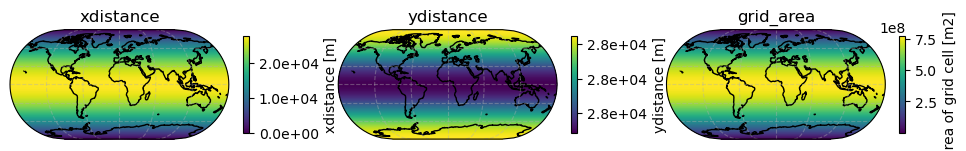

In [37]:
properties.plot_properties('grid')

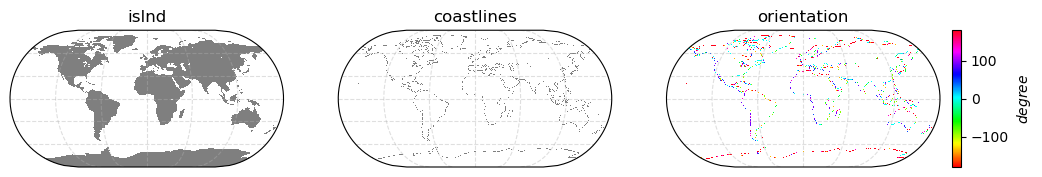

In [40]:
properties.plot_properties('land')

#### Smoothing scale calculated from grid area and input

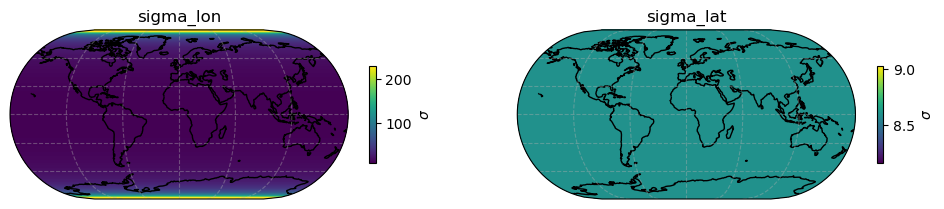

In [41]:
properties.plot_properties('smooth')

## Segmentation

### Smoothing

In [10]:
stime = time.time()
rdetect = rd.ridgeDetector(cyc)
vor = rdetect.apply_smoother(cyc,properties)
print('Finished smoothing in {} seconds'.format(time.time()-stime))

Finished smoothing in 29.058950185775757 seconds


### Shape Extraction

In [11]:
stime = time.time()
vor = vor.rename({'rv':'mag'})
cyc = cyc.rename({'rv':'mag'})
# Select only positive values of cyclonic vorticity
cyc_sm = vor.where((vor.mag>0)).fillna(0)
# Detect Ridges
ridges = rdetect.apply_ridge_detection(cyc_sm,properties)
print('Finished ridge extraction in {} seconds'.format(time.time()-stime))

/Users/mac/miniconda3/envs/iccp/lib/python3.10/site-packages/pint/facets/plain/quantity.py:1119: RuntimeWarning: invalid value encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/Users/mac/miniconda3/envs/iccp/lib/python3.10/site-packages/pint/facets/plain/quantity.py:1119: RuntimeWarning: divide by zero encountered in divide
  magnitude = magnitude_op(new_self._magnitude, other._magnitude)
/Users/mac/miniconda3/envs/iccp/lib/python3.10/site-packages/pint/facets/plain/quantity.py:879: RuntimeWarning: invalid value encountered in subtract
  magnitude = op(self._magnitude, other._magnitude)


Finished ridge extraction in 264.48995304107666 seconds


### Secondary Field

In [12]:
# Use unsmoothed vorticity as primary field 
cyc_us = cyc.where((cyc.mag>0)).fillna(0)
# Define the secondary field as wind speed
ws = np.sqrt(u['u10']**2+v['v10']**2)
props_mag = xr.concat([ws.expand_dims('Channel'),\
                    cyc_us.mag.expand_dims('Channel')], dim='Channel')
props_mag = props_mag.to_dataset(name='mag')

Error:DAP DATADDS packet is apparently too short


## Filtering

In [13]:
stime = time.time()
obfilter = obf.filterObjects(ridges)
filtered = obfilter.apply_filter(ridges,\
            props_mag,['max_intensity','mean_intensity'],
            [10,2e-5],properties,'ridges')
print('Finished Filtering in {} seconds'.format(time.time()-stime))

Finished Filtering in 861.4567539691925 seconds


## Tracking

In [16]:
ar_objects = filtered[1]
ar_props = filtered[0]

# Tracking
properties.obj['Min_Duration']=48
properties.obj['Max_Distance']=500

# Tracking based on centroid of each object
latlon = ['wclat','wclon']

tracker = obt.Tracker(latlon,properties)
tracked = tracker.apply_tracking(ar_props,ar_objects)

  0%|                                                                                              | 0/118 [00:00<?, ?it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
  1%|▋                                                                                     | 1/118 [00:00<00:49,  2.36it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

 13%|██████████▊                                                                          | 15/118 [00:06<00:47,  2.16it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
 14%|███████████▌                                                                         | 16/118 [00:06<00:48,  2.09it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

 25%|█████████████████████▌                                                               | 30/118 [00:13<00:43,  2.00it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
 26%|██████████████████████▎                                                              | 31/118 [00:14<00:43,  1.98it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

 38%|████████████████████████████████▍                                                    | 45/118 [00:21<00:33,  2.16it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
 39%|█████████████████████████████████▏                                                   | 46/118 [00:21<00:32,  2.23it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

 51%|███████████████████████████████████████████▏                                         | 60/118 [00:27<00:22,  2.52it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
 52%|███████████████████████████████████████████▉                                         | 61/118 [00:27<00:23,  2.47it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

 64%|██████████████████████████████████████████████████████                               | 75/118 [00:33<00:18,  2.39it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
 64%|██████████████████████████████████████████████████████▋                              | 76/118 [00:33<00:17,  2.37it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

 76%|████████████████████████████████████████████████████████████████▊                    | 90/118 [00:38<00:11,  2.44it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
 77%|█████████████████████████████████████████████████████████████████▌                   | 91/118 [00:39<00:12,  2.24it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

 89%|██████████████████████████████████████████████████████████████████████████▋         | 105/118 [00:46<00:06,  1.94it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  df = pd.concat([df,nandframe])
 90%|███████████████████████████████████████████████████████████████████████████▍        | 106/118 [00:47<00:06,  1.85it/s]/Users/mac/부산대학교산학협력단 Dropbox/Arjun N.B/Dropbox Personal/GitHub/SCAFET/Git/src/object_tracking.py:323: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the o

In [56]:
tracked[0]

<xarray.Dataset>
Dimensions:             (id: 291)
Coordinates:
  * id                  (id) object 1.0 1.0 1.0 1.0 ... 139.0 145.0 145.0 145.0
Data variables: (12/39)
    mean_intensity-0    (id) object 120142092.14731053 ... 542315917.2031018
    mean_intensity-1    (id) object 6.262796303505374 ... 6.502689395163887
    mean_intensity-2    (id) object 3.44651544531623e-05 ... 5.65995641052689...
    min_intensity-0     (id) object 90828959.45741372 ... 522074558.18083715
    min_intensity-1     (id) object 0.6751485466957092 ... 0.5878952145576477
    min_intensity-2     (id) object 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ...                  ...
    track_ids           (id) object 1.0 1.0 1.0 1.0 ... 139.0 145.0 145.0 145.0
    travelled_distance  (id) object nan 2.4314333840434945 ... 83.87956501121813
    tstep               (id) object 1 2 3 4 1 2 3 4 1 2 ... 4 2 3 4 2 3 4 2 3 4
    label               (id) object 1 1 1 1 2 2 2 2 ... 57 56 59 59 58 65 65 64
    timestamp           (id) object 1696100399999997000 ... 1696111199999997000
    old_label           (id) object 5.0 5.0 7.0 5.0 ... 724.0 829.0 838.0 816.0

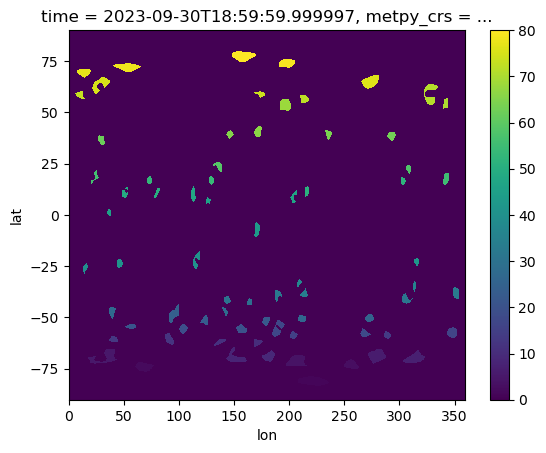

In [58]:
tracked[1].isel(time=0).plot()